In [146]:
import torch
import torch.nn as nn
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
import matplotlib.pyplot as plt
import os
import librosa
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [153]:
class Encoder(nn.Module):
    def __init__(self, image_channels, kernel, stride):
        super(Encoder, self).__init__()

        # [b, 128, 345]
        
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 8, kernel, stride=stride), # [b, 8, 63, 172]
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel, stride=stride), # [b, 16, 31, 85]
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel, stride=stride), # [b, 32, 16, 44]
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.AvgPool2d((2,2)) # [b, 32, 6, 20]
        )
        
    def forward(self, x):
        x = self.encoder(x)
        # print(x.shape)
        return x.view(x.size(0), -1), x.shape  # flatten

class Decoder(nn.Module):
        def __init__(self, image_channels, h_dim, z_dim, kernel, stride):
            super(Decoder, self).__init__()

            self.fc_up = nn.Linear(z_dim, h_dim)
            
            self.decoder = nn.Sequential(
                nn.ConvTranspose2d(32, 32, 2, stride=2), # [b, 126, 343]
                nn.BatchNorm2d(32),
                nn.ReLU(),
                nn.ConvTranspose2d(32, 16, kernel, stride=stride, output_padding=(1,0)), # [b, 126, 343]
                nn.BatchNorm2d(16),
                nn.ReLU(),
                nn.ConvTranspose2d(16, 8, kernel+1, stride=stride, output_padding=(1,0)),
                nn.BatchNorm2d(8),
                nn.ReLU(),
                nn.ConvTranspose2d(8, image_channels, kernel+2, stride=stride, output_padding=(1,0)),
                nn.Sigmoid()
                    )
            
        def forward(self, x, resize):
            x = self.fc_up(x)
            # print("Upsample: ", x.shape)
            x = x.view(resize[0], resize[1], resize[2], resize[3])
            # print("Reshaped: ", x.shape) # [b, 32, 6, 20]
            return self.decoder(x)
    
class VAE(nn.Module):
    def __init__(self, Enc, Dec, h_dim, z_dim):
        super(VAE, self).__init__()

        # [b, 128, 345]
        
        self.encoder = Enc
        self.decoder = Dec
        
        self.fc_mean = nn.Linear(h_dim, z_dim)
        self.fc_var = nn.Linear(h_dim, z_dim)
        
    def reparameterize(self, mean, var):
        std = var.mul(0.5).exp_()
        esp = torch.randn(*mean.size())
        z = mean + std * esp
        return z
    
    def forward(self, x):
        # Dropout
        # x = self.dropout(x)

        # print(x.shape)        
        # Encode
        x, s = self.encoder(x)

        # print("Output Encoder: ", x.shape)

        # Latent Sampling
        mean, var = self.fc_mean(x), self.fc_var(x)
        z = self.reparameterize(mean, var)

        # print("Output Latent: ", z.shape)

        # Decode
        z = self.decoder(z, s)

        # print("Final Out: ", z.shape)
        return z, mean, var
            

In [154]:
h_dim, z_dim, img_c = 3840, 512, 1

E = Encoder(image_channels=img_c,
            kernel=5,
            stride=2)
D = Decoder(image_channels=img_c, 
            kernel=5,
            stride=2,
            h_dim=h_dim, z_dim=z_dim)

model = VAE(E, D, h_dim=h_dim, z_dim=z_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 

In [155]:
print(model)

VAE(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(8, 16, kernel_size=(5, 5), stride=(2, 2))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
      (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
      (9): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
    )
  )
  (decoder): Decoder(
    (fc_up): Linear(in_features=512, out_features=3840, bias=True)
    (decoder): Sequential(
      (0): ConvTranspose2d(32, 32, kernel_size=(2, 2), stride=(2, 2))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): ConvTranspose2d(32, 16, kernel_size=(5, 5), stride=(2, 2)

In [156]:
r = torch.rand(16, 1, 128,345)
enc_out, shape_out = E(r)

In [157]:
# r = torch.rand(16, 512)
# dec_out = D(r, torch.Size([16, 32, 6, 20]))

In [158]:
x = model(r)

In [159]:
torchaudio.set_audio_backend("soundfile")

SAMPLE_SPEECH = "../slices/slice_0.wav"
metadata = torchaudio.info(SAMPLE_SPEECH)
print(metadata)

def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")

AudioMetaData(sample_rate=44100, num_frames=176400, num_channels=1, bits_per_sample=16, encoding=PCM_S)


C:\Users\Brock\AppData\Local\Temp\ipykernel_27512\301072133.py:1: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("soundfile")


In [160]:
n_fft = 1024
win_length = None
hop_length = 512
n_mels = 128
sample_rate = metadata.sample_rate
PATH = "../slices"

mel_spectrogram = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm="slaney",
    n_mels=n_mels,
    mel_scale="htk",
)

In [161]:
data = []

for x in os.listdir(PATH):
    SPEECH_WAVEFORM, SAMPLE_RATE = torchaudio.load(PATH + "/" + x)
    data.append(SPEECH_WAVEFORM)

In [162]:
mels = mel_spectrogram(torch.cat(data))

In [163]:
mels.shape

torch.Size([1024, 128, 345])

In [164]:
comparison = mels[0]

In [165]:
mels = mels.reshape(mels.size(0), -1)
mels -= mels.min(1, keepdim=True)[0]
mels /= mels.max(1, keepdim=True)[0]
mels = mels.view(mels.size(0), 1, 128, 345)

In [166]:
mels.shape

torch.Size([1024, 1, 128, 345])

In [167]:
mels.min(), mels.max()

(tensor(0.), tensor(1.))

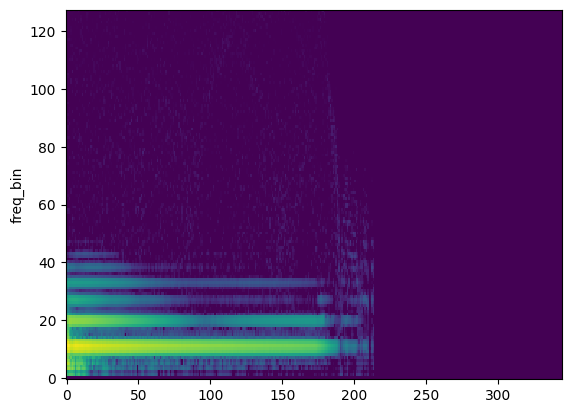

In [168]:
plot_spectrogram(mels[0].reshape(128, 345))

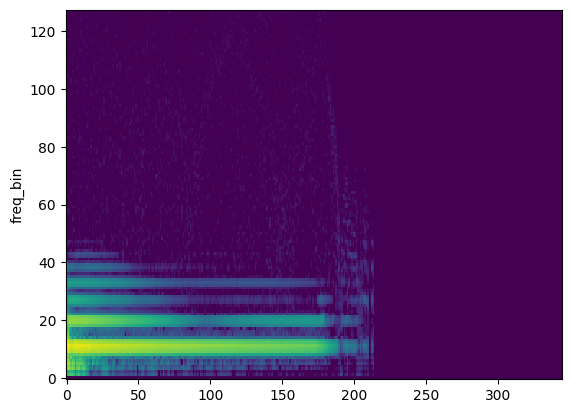

In [169]:
plot_spectrogram(comparison)

In [170]:
mse = torch.square(comparison - mels[0].reshape(128, 345)).mean().item()
print(mse)

0.00019666850857902318


# Don't Normalize

In [27]:
print(mels.shape, mels.max(), mels.min())

torch.Size([1024, 128, 345]) tensor(1060.1697) tensor(0.)


In [28]:
mean, std, var = torch.mean(mels), torch.std(mels), torch.var(mels)

print(mean, std, var)

tensor(0.0201) tensor(1.1140) tensor(1.2409)


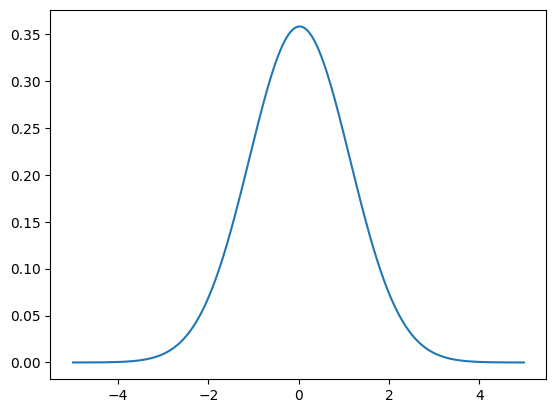

In [29]:
from scipy.stats import norm
import numpy as np

x_axis = np.arange(-5, 5, 0.01) 
plt.plot(x_axis, norm.pdf(x_axis, mean, std)) 
plt.show() 

In [30]:
mels = (mels-mean) / std

In [31]:
torch.mean(mels), torch.std(mels), torch.var(mels)

(tensor(-3.4553e-10), tensor(1.), tensor(1.))

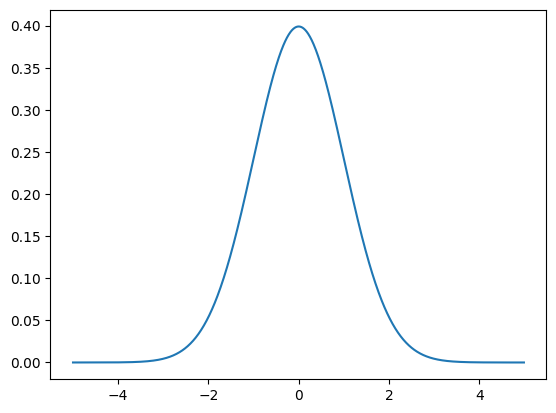

In [32]:
plt.plot(x_axis, norm.pdf(x_axis, torch.mean(mels), torch.std(mels))) 
plt.show() 

In [33]:
print(mels.shape, mels.max(), mels.min())

torch.Size([1024, 128, 345]) tensor(951.6960) tensor(-0.0181)


# Training

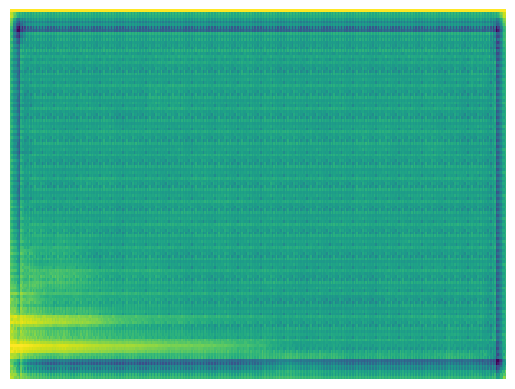

In [180]:
def generate():
    z_sample = torch.rand(1,512)#.to(device)
    # print(z_sample.max(), z_sample.min())
    x_decoded = D(z_sample, (1, 32, 6, 20))
    plot_spectrogram(x_decoded.detach().cpu().reshape(128,345))
    plt.axis('off')
    plt.show()

generate()

In [181]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [182]:
dataset = torch.utils.data.TensorDataset(mels, mels)

batch_size = 16
train_loader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)

	Epoch 1 	Average Loss:  401.3517824203249


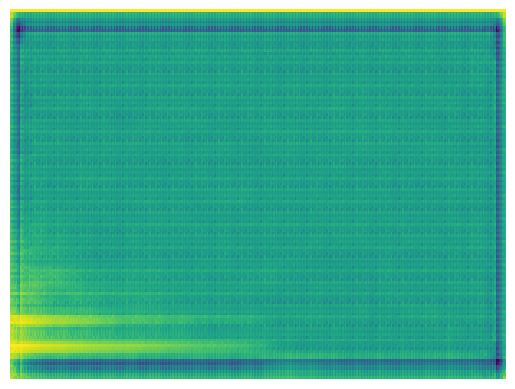

	Epoch 2 	Average Loss:  398.8833298456101


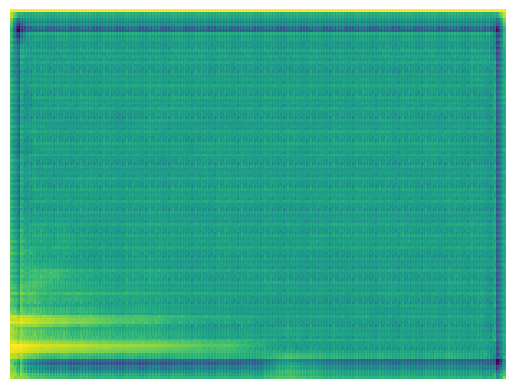

	Epoch 3 	Average Loss:  396.49862622457835


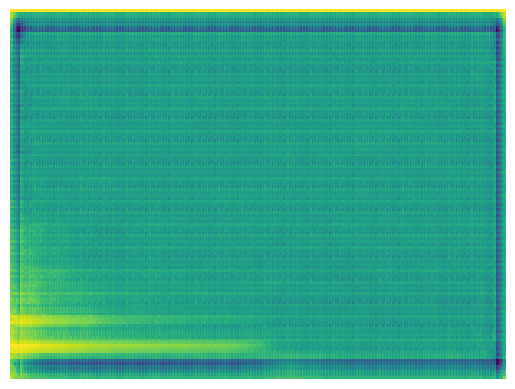

	Epoch 4 	Average Loss:  395.00936647445434


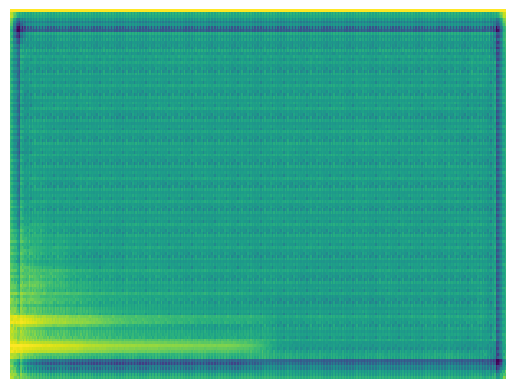

	Epoch 5 	Average Loss:  392.9917607383123


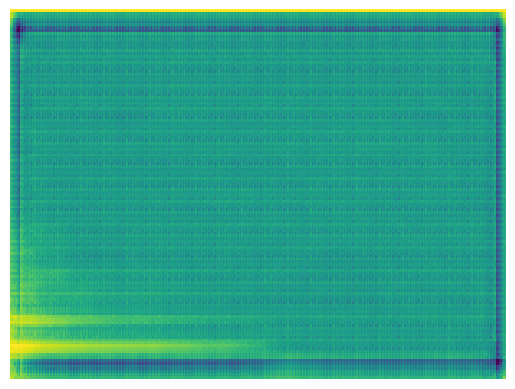

	Epoch 6 	Average Loss:  390.7150670611669


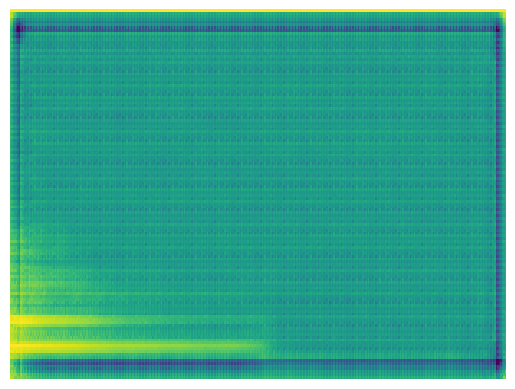

	Epoch 7 	Average Loss:  389.07319810655383


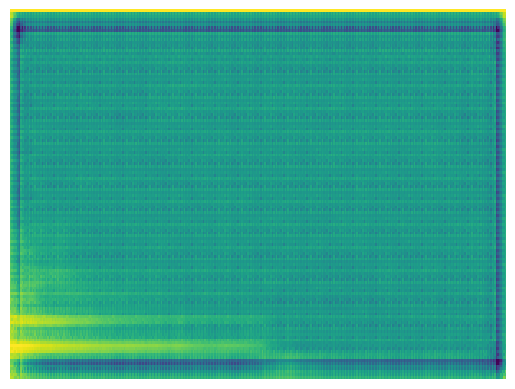

	Epoch 8 	Average Loss:  386.9420960441468


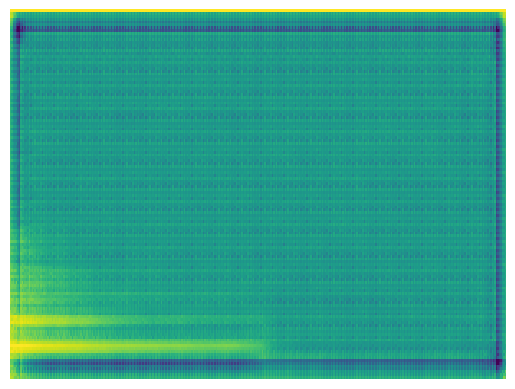

	Epoch 9 	Average Loss:  385.30757988823785


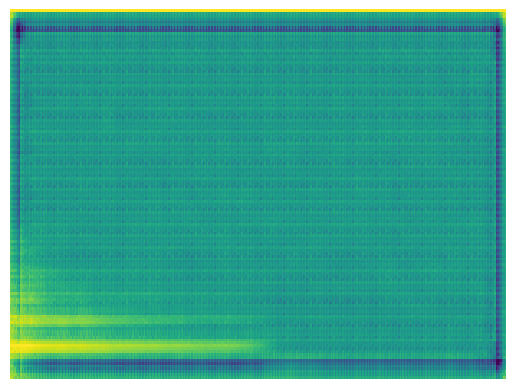

	Epoch 10 	Average Loss:  382.93666100880455


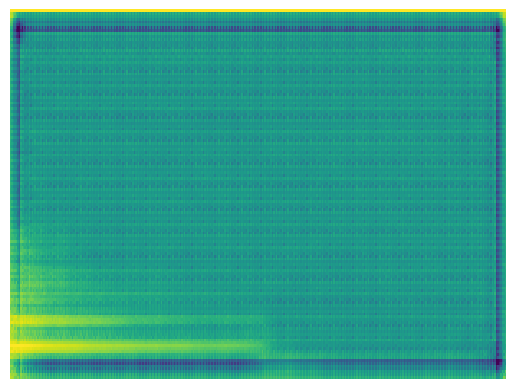

	Epoch 11 	Average Loss:  381.28268141973587


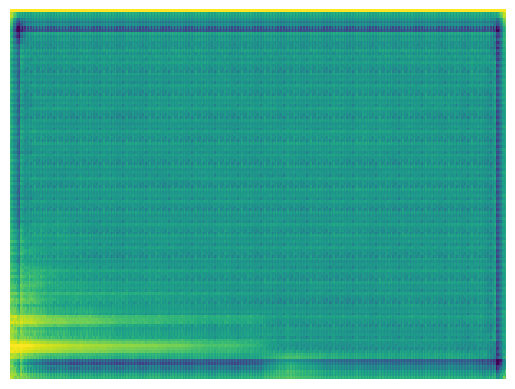

	Epoch 12 	Average Loss:  379.6835428873698


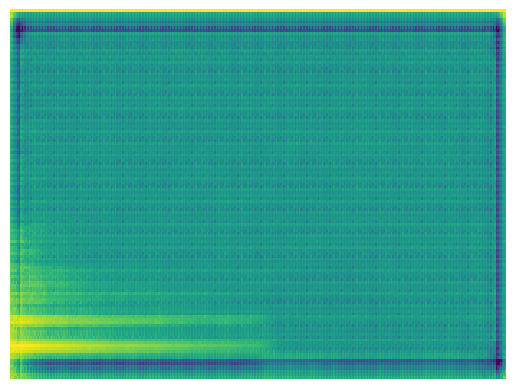

	Epoch 13 	Average Loss:  377.95220850384425


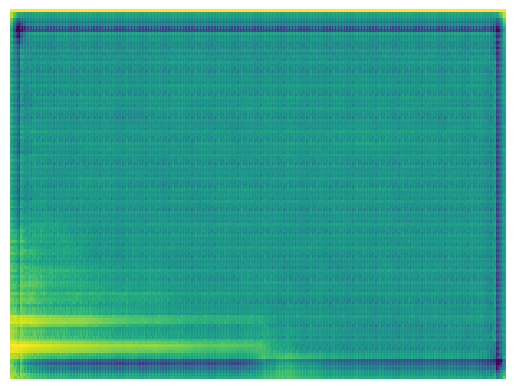

	Epoch 14 	Average Loss:  375.4496217757937


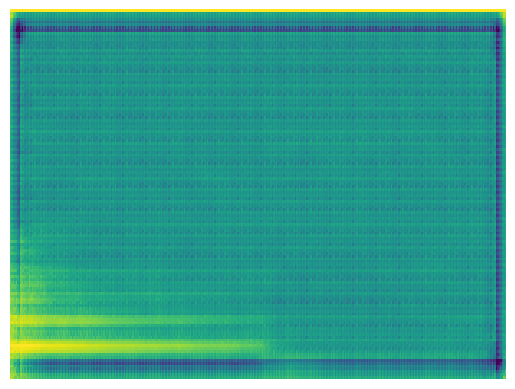

	Epoch 15 	Average Loss:  373.5210673014323


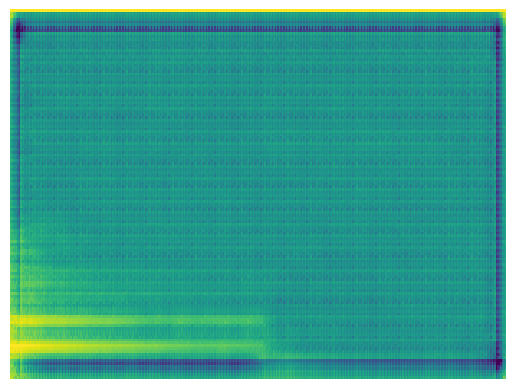

	Epoch 16 	Average Loss:  371.8576916891431


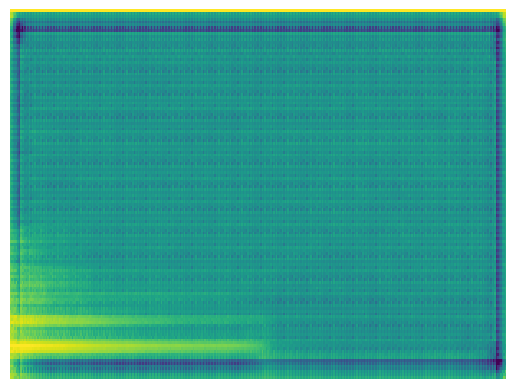

	Epoch 17 	Average Loss:  370.38535563151044


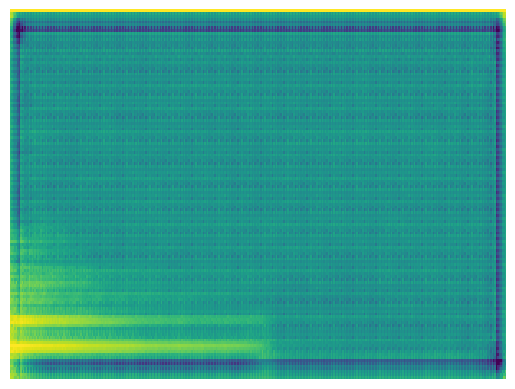

	Epoch 18 	Average Loss:  368.2582857646639


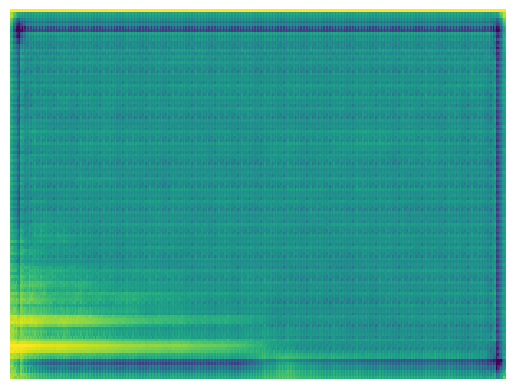

	Epoch 19 	Average Loss:  366.03817700582835


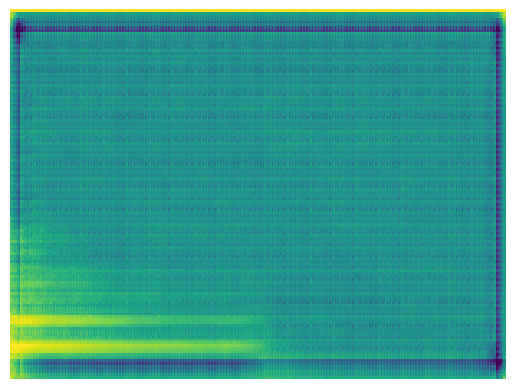

	Epoch 20 	Average Loss:  364.1315709674169


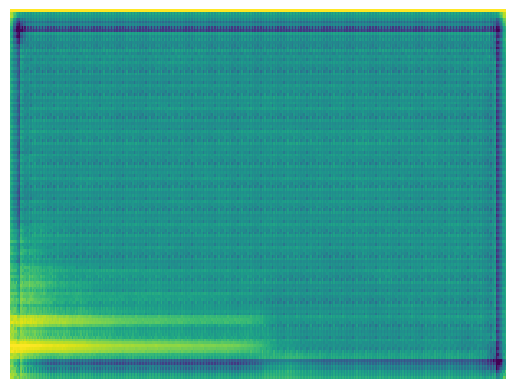

	Epoch 21 	Average Loss:  362.08856394934276


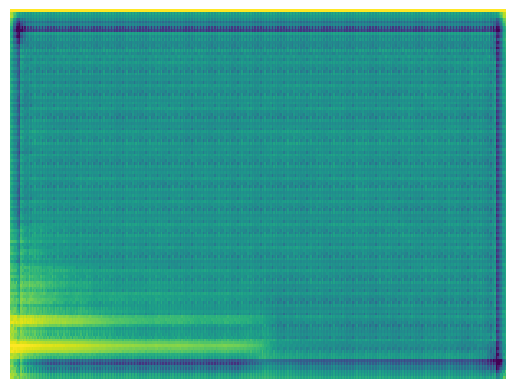

	Epoch 22 	Average Loss:  359.6991703093998


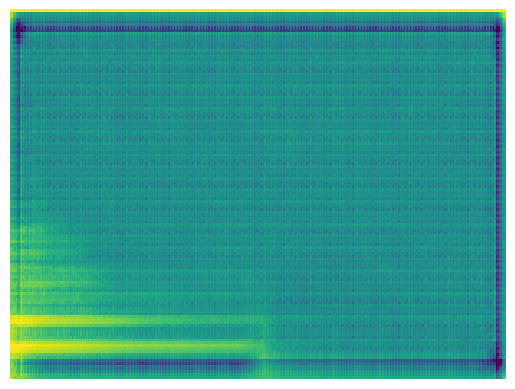

	Epoch 23 	Average Loss:  357.6346503363715


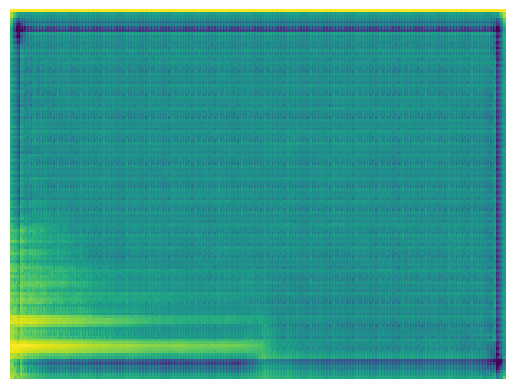

	Epoch 24 	Average Loss:  355.71268959650916


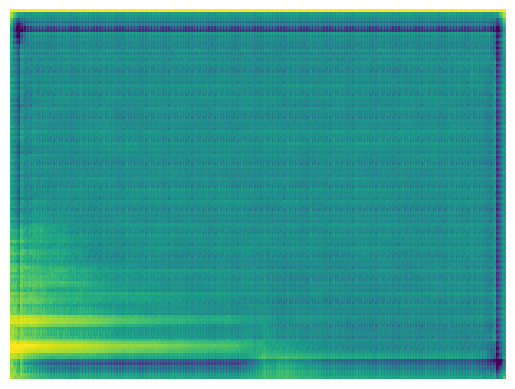

	Epoch 25 	Average Loss:  353.7352454775856


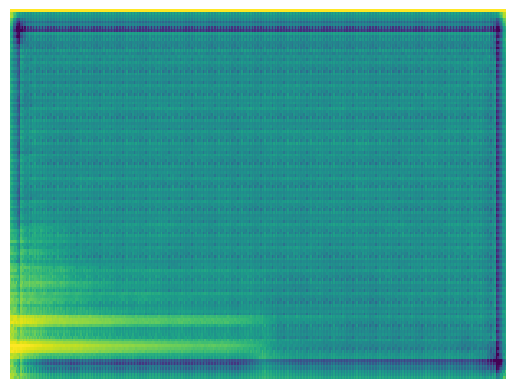

	Epoch 26 	Average Loss:  352.5873752170139


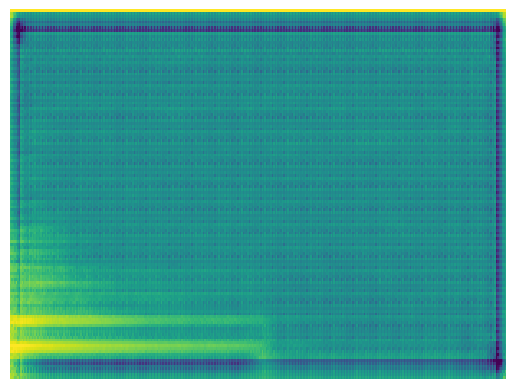

	Epoch 27 	Average Loss:  349.66998387896825


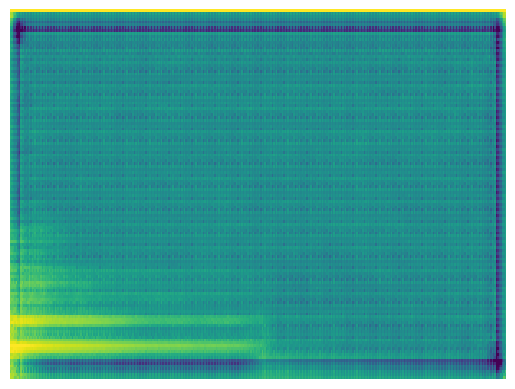

	Epoch 28 	Average Loss:  348.1820673866877


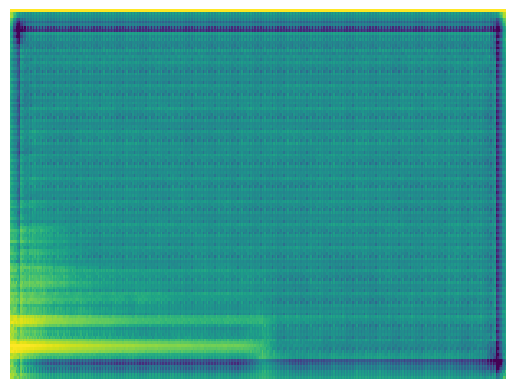


KeyboardInterrupt



In [183]:
def train(model, optimizer, epochs, device):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.view(batch_size, 1, 128, 345).to(device)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)
            
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
        generate()
    return overall_loss

train(model, optimizer, epochs=100, device=device)

In [88]:
def plot_latent_space(model, scale=1.0, n=25, digit_size=28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid 
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(model)

NameError: name 'device' is not defined